# day23: Introduction to autograd for gradient descent


# Objectives

We will practice:

* Using the **autograd** Python package to compute gradients of functions
* Using gradients from autograd to do a basic linear regression

# Outline

* [Part 1: Autograd for scalar input, scalar output functions](#part1)
* [Part 2: Autograd for vector input, scalar output functions](#part2)
* [Part 3: Using autograd with simple gradient descent procedure](#part3)
* [Part 4: Using autograd to solve linear regression](#part4)
* [Part 5: Using autograd with functions that take dicts and other data structures](#part5)


# Takeaways

* Automatic differentiation is a powerful idea that has made experimenting with different models and loss functions far easier than it was even 8 years ago.
* The Python package `autograd` is a wonderfully simple tool that makes this work with numpy/scipy

* `autograd` works by a super-smartly implemented version of the backpropagation dynamic programming we've already discussed from Unit 3
* * Basically, after doing a "forward" pass to evaluate the function, we do a "reverse" pass through the computation graph and compute gradients via the chain rule.
* * This general purpose method is called [reverse-mode differentiation](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md#reverse-mode-differentiation)

* `autograd` does NOT do symbolic math!
* * e.g. It does not simplify `ag_np.sqrt(ag_np.square(x))` as `x`. It will use the chain rule on all nested functions that the user specifies.
* `autograd` does NOT do numerical approximations to gradients.
* * e.g. It does not estimate gradients by perturbing inputs slightly

* In Part 5, we see how we can define losses in terms of dictionaries, which let us define complicated models with many different parameters. We'll exploit this in Project C for matrix factorization with many parameters

# Limitations

FYI There are some things that autograd *cannot* handle that you should be aware of. 

Make sure any loss function you define that you want to differentiate does not do any of these things:

* Do not use assignment to elements of arrays, like `A[0] = x` or `A[1] = y`
* * Instead, compute entries individually and then stack them together.
* * Like this: `x = ...; y = ...; A = ag_np.hstack([x, y])`
* Do not rely on implicit casting of lists to arrays, like `A = ag_np.sum([x, y])`
* * use `A = ag_np.sum(ag_np.array([x, y]))` instead.
* Do not use A.dot(B) notation
* * Instead, use `ag_np.dot(A, B)`
* Avoid in-place operations (such as `a += b`)
* * Instead, use a = a + b

# Further Reading

Check out these great resources

* Official tutorial for the autograd package: https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
* Short list of what autograd *can* and *cannot* do: https://github.com/HIPS/autograd/blob/master/docs/tutorial.md#supported-and-unsupported-parts-of-numpyscipy



In [1]:
## Import numpy
import numpy as np
import pandas as pd
import copy

In [2]:
## Import autograd
import autograd.numpy as ag_np
import autograd

In [3]:
# Import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

<a name="part1"></a>

# PART 1: Using autograd.grad for univariate functions

Suppose we have a mathematical function of interest $f(x)$.

For now, we'll assume this function has a scalar input and scalar output. This means:

* $x \in \mathbb{R}$
* $f(x) \in \mathbb{R}$

We can ask: what is the derivative (aka *gradient*) of this function:

$$
g(x) \triangleq \frac{\partial}{\partial x} f(x)
$$

Instead of computing this gradient by hand via calculus/algebra, we can use `autograd` to do it for us.

First, we need to implement the math function $f(x)$ as a **Python function** `f`.

The Python function `f` needs to satisfy the following requirements:
* INPUT 'x': scalar float
* OUTPUT 'f(x)': scalar float
* All internal operations are composed of calls to functions from `ag_np`, the `autograd` version of numpy

### From numpy to autograd's wrapper of numpy

You might be used to importing numpy as `import numpy as np`, and then using this shorthand for `np.cos(0.0)` or `np.square(5.0)` etc.

For autograd to work, you need to instead use **autograd's** provided numpy wrapper interface:

`from autograd.numpy as ag_np`

The `ag_np` module has the same API as `numpy`. So for example, you can call

* `ag_np.cos(0.0)`
* `ag_np.square(5.0)`
* `ag_np.sum(a_N)`
* `ag_np.mean(a_N)`
* `ag_np.dot(u_NK, v_KM)`

Or almost any other function you usually would use with `np`

**Summary:** Make sure your function `f` produces a scalar and only uses functions within the `ag_np` wrapper



### Example: f(x) = x^2

$$
f(x) = x^2
$$

In [4]:
def f(x):
    return ag_np.square(x)

In [5]:
f(0.0)

0.0

In [6]:
f(1.0)

1.0

In [7]:
f(2.0)

4.0

### Computing gradients with autograd

Given a Python function `f` that meets our requirements and evaluates $f(x)$, we want a Python function ``g` that computes the gradient $g(x) \triangleq \frac{\partial}{\partial x}$

We can use `autograd.grad` to create a Python function `g` 

```
g = autograd.grad(f) # create function g that produces gradients of input function f
```

The symbol `g` is now a **Python function** that takes the same input as `f`, but produces the derivative at a given input.



In [8]:
g = autograd.grad(f)

In [9]:
# 'g' is just a function.
# You can call it as usual, by providing a possible scalar float input

g(0.0)

0.0

In [10]:
g(1.0)

2.0

In [11]:
g(2.0)

4.0

In [12]:
g(3.0)

6.0

### Discussion 1a: Do you agree that the printed values above are correct? Why or why not?

In [ ]:
# TODO discuss

### Plot to demonstrate the gradient function  side-by-side with original function

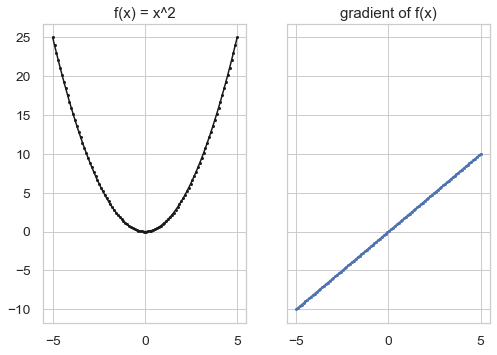

In [13]:
# Input values evenly spaced between -5 and 5
x_grid_G = np.linspace(-5, 5, 100)

fig_h, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, squeeze=False)
subplot_grid[0,0].plot(x_grid_G, [f(x_g) for x_g in x_grid_G], 'k.-')
subplot_grid[0,0].set_title('f(x) = x^2')

subplot_grid[0,1].plot(x_grid_G, [g(x_g) for x_g in x_grid_G], 'b.-')
subplot_grid[0,1].set_title('gradient of f(x)');

### Exercise 1b:

Consider the decaying periodic function below. Can you compute its derivative using autograd and plot the result?

$$
f(x) = e^{-x/10} * cos(x)
$$

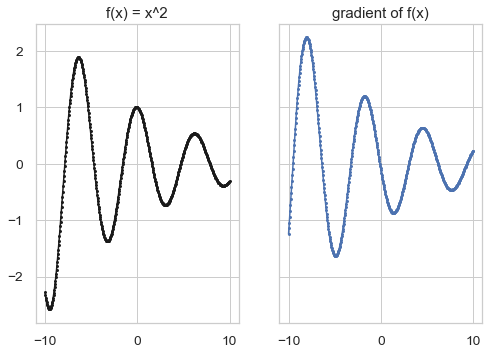

In [14]:
def f(x):
    return ag_np.exp(-x/10) * ag_np.cos(x)
    
g = autograd.grad(f) # TODO define g as gradient of f, using autograd's `grad` 

# TODO plot the result
x_grid_G = np.linspace(-10, 10, 500)
fig_h, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, squeeze=False)
subplot_grid[0,0].plot(x_grid_G, [f(x_g) for x_g in x_grid_G], 'k.-');
subplot_grid[0,0].set_title('f(x) = x^2');

subplot_grid[0,1].plot(x_grid_G, [g(x_g) for x_g in x_grid_G], 'b.-');
subplot_grid[0,1].set_title('gradient of f(x)');

# PART 2: Using autograd.grad for functions with multivariate input


Now, imagine the input $x$ could be a vector of size D. 

Our mathematical function $f(x)$ will map each input vector to a scalar.

We want the gradient function

\begin{align}
g(x) &\triangleq \nabla_x f(x)
\\
&= [
    \frac{\partial}{\partial x_1} f(x)
    \quad \frac{\partial}{\partial x_2} f(x)
    \quad \ldots \quad \frac{\partial}{\partial x_D} f(x)  ]
\end{align}

Instead of computing this gradient by hand via calculus/algebra, we can use autograd to do it for us.

First, we implement math function $f(x)$ as a **Python function** `f`.

The Python function `f` needs to satisfy the following requirements:
* INPUT 'x': numpy array of float
* OUTPUT 'f(x)': scalar float
* All internal operations are composed of calls to functions from `ag_np`, the `autograd` version of numpy


### Worked Example 2a

Let's set up a function that is defined as the inner product of the input vector x with some weights $w$

We assume both $x$ and $w$ are $D$ dimensional vectors

$$
f(x) = \sum_{d=1}^D x_d w_d
$$


Define the fixed weights

In [15]:
D = 2

w_D = np.asarray([1., 2.,])

Define the function `f` using `ag_np` wrapper functions only

In [16]:
def f(x_D):
    return ag_np.dot(x_D, w_D) # dot product is just inner product in this case

Use `autograd.grad` to get the gradient function `g`

In [17]:
g = autograd.grad(f)

Try putting in the all-zero vector

In [18]:
x_D = np.zeros(D)

print("x_D", x_D)
print("f(x_D) = %.3f" % (f(x_D)))

x_D [0. 0.]
f(x_D) = 0.000


Compute the gradient wrt that all-zero vector

In [19]:
g(x_D)

array([1., 2.])

Try another input vector

In [20]:
x_D = np.asarray([1., 2.])

print("x_D", x_D)
print("f(x_D) = %.3f" % (f(x_D)))

x_D [1. 2.]
f(x_D) = 5.000


Compute the gradient wrt the vector [1, 2, 3]

In [21]:
g(x_D)

array([1., 2.])

### Discussion 2b: Does this gradient computation agree with what you expect?

In [ ]:
# TODO discuss

### Exercise 2c:

Let's set up a function that is just the sum-of-squares penalty on the input vector x

$$
f(x) = \sum_{d=1}^D x_d^2
$$

Define the function `f` using `ag_np` wrapper functions only

In [22]:
def f(x_D):
    return ag_np.sum(x_D * x_D) # TODO define sum-of-squares function f via calls to ag_np functions

Use `autograd.grad` to get the gradient function `g`

In [23]:
g = autograd.grad(f)

Try out an input vector

In [24]:
x_D = np.asarray([1., 2.])

print("x_D", x_D)
print("f(x_D) = %.3f" % (f(x_D)))

x_D [1. 2.]
f(x_D) = 5.000


Compute the gradient.

In [25]:
g(x_D)

array([2., 4.])

### Discussion 2d: Mathematically, should the gradient of sum-of-squares function be when x is all zero? Does your function `g` agree?

TODO try out feeding `np.zeros(D)` into your `g` function and discuss if you get what you expect

In [26]:
g(np.zeros(D))

array([0., 0.])

# Part 3: Using autograd gradients within gradient descent to solve multivariate optimization problems

### Helper function: basic gradient descent

Here's a very simple function that will perform many gradient descent steps to optimize a given function.



In [27]:
def run_many_iters_of_gradient_descent(f, g, init_x_D=None, n_iters=100, step_size=0.001):
    ''' Run many iterations of GD
    
    Args
    ---- 
    f : python function (D,) to float
        Maps vector x_D to scalar loss
    g : python function, (D,) to (D,)
        Maps vector x_D to gradient g_D
    init_x_D : 1D array, shape (D,)
        Initial value for the input vector
    n_iters : int
        Number of gradient descent update steps to perform
    step_size : positive float
        Step size or learning rate for GD
        
    Returns
    -------
    x_D : 1D array, shape (D,)
        Best value of input vector for provided loss f found via this GD procedure
    history : dict
        Contains history of this GD run useful for plotting diagnostics
    '''
    # Copy the initial parameter vector
    x_D = copy.deepcopy(init_x_D)

    # Create data structs to track the per-iteration history of different quantities
    history = dict(
        iter=[],
        f=[],
        x_D=[],
        g_D=[])

    for iter_id in range(n_iters):
        if iter_id > 0:
            x_D = x_D - step_size * g(x_D)

        history['iter'].append(iter_id)
        history['f'].append(f(x_D))
        history['x_D'].append(x_D)
        history['g_D'].append(g(x_D))
    return x_D, history

### Worked Example 3a: Minimize f(x) = sum(square(x))

It's easy to figure out that the vector with smallest L2 norm (smallest sum of squares) is the all-zero vector.

Here's a quick example of showing that using gradient functions provided by autograd can help us solve the optimization problem:

$$
\min_x  \sum_{d=1}^D x_d^2
$$

In [28]:
def f(x_D):
    return ag_np.sum(ag_np.square(x_D))

g = autograd.grad(f)

# Initialize at x_D = [6, 4, -3, -5]
D = 4
init_x_D = np.asarray([6.0, 4.0, -3.0, -5.0])

In [29]:
opt_x_D, history = run_many_iters_of_gradient_descent(f, g, init_x_D, n_iters=1000, step_size=0.01)

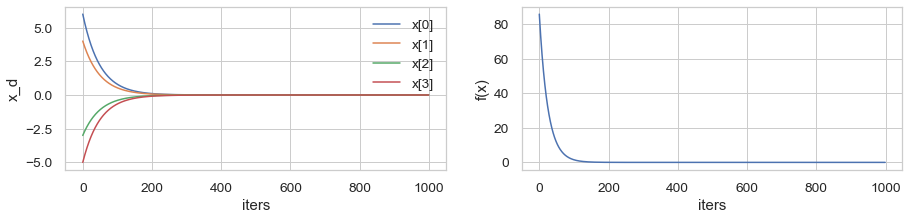

In [30]:
# Make plots of how x parameter values evolve over iterations, and function values evolve over iterations
# Expected result: f goes to zero. all x values goto zero.

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
for d in range(D):
    subplot_grid[0,0].plot(history['iter'], np.vstack(history['x_D'])[:,d], label='x[%d]' % d);
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('x_d')
subplot_grid[0,0].legend(loc='upper right')

subplot_grid[0,1].plot(history['iter'], history['f'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('f(x)');

### Exercise 3b: Minimize the 'trid' function

Given a 2-dimensional vector $x = [x_1, x_2]$, the trid function is:

$$
f(x) = (x_1-1)^2 + (x_2-1)^2 - x_1 x_2
$$

Background and Picture: <https://www.sfu.ca/~ssurjano/trid.html>

Can you use autograd + gradient descent to find the optimal value $x^*$ that minimizes $f(x)$?

You can initialize your gradient descent at [+1.0, -1.0]

In [37]:
def f(x_D):
    return ag_np.power(x_D[0] - 1, 2) + ag_np.power(x_D[1] - 1, 2) - (x_D[0] * x_D[1]) # TODO

g = autograd.grad(f) # TODO
# Initialize at x_D = [6, 4, -3, -5]
D = 4
init_x_D = np.asarray([6.0, 4.0, -3.0, -5.0])

In [38]:
# TODO call run_many_iters_of_gradient_descent() with appropriate args

opt_x_D, history = run_many_iters_of_gradient_descent(f, g, init_x_D, n_iters=1000, step_size=0.01)

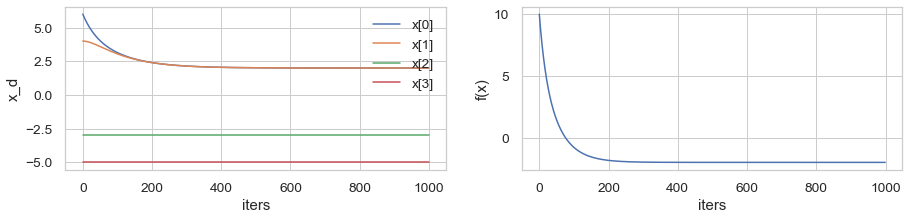

In [39]:
# TRID example
# Make plots of how x parameter values evolve over iterations, and function values evolve over iterations
# Expected result: ????

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
for d in range(D):
    subplot_grid[0,0].plot(history['iter'], np.vstack(history['x_D'])[:,d], label='x[%d]' % d);
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('x_d')
subplot_grid[0,0].legend(loc='upper right')

subplot_grid[0,1].plot(history['iter'], history['f'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('f(x)');

# Part 4: Solving linear regression with gradient descent + autograd

We observe $N$ examples $(x_n, y_n)$ consisting of D-dimensional 'input' vectors $x_n$ and scalar outputs $y_n$.

Consider the multivariate linear regression model for making a prediction given any input vector $x_i \in \mathbb{R}^D$:

\begin{align}
\hat{y}(x_i) = w^T x_i
\end{align}

One way to train weights would be to just compute the weights that minimize mean squared error

\begin{align}
\min_{w \in \mathbb{R}^D}  \sum_{n=1}^N (y_n - x_n^T w )^2
\end{align}


### Toy Data for linear regression task

We'll generate data that comes from an idealized linear regression model.

Each example has D=2 dimensions for x.

* The first dimension is weighted by +4.2.

* The second dimension is weighted by -4.2


In [40]:
N = 100
D = 2
sigma = 0.1

true_w_D = np.asarray([4.2, -4.2])
true_bias = 0.1

train_prng = np.random.RandomState(0)
x_ND = train_prng.uniform(low=-5, high=5, size=(N,D))
y_N = np.dot(x_ND, true_w_D) + true_bias + sigma * train_prng.randn(N)

### Toy Data Visualization: Pairplots for all possible (x_d, y) combinations

You can clearly see the slopes of the lines:
* x1 vs y plot: slope is around +4
* x2 vs y plot: slope is around -4

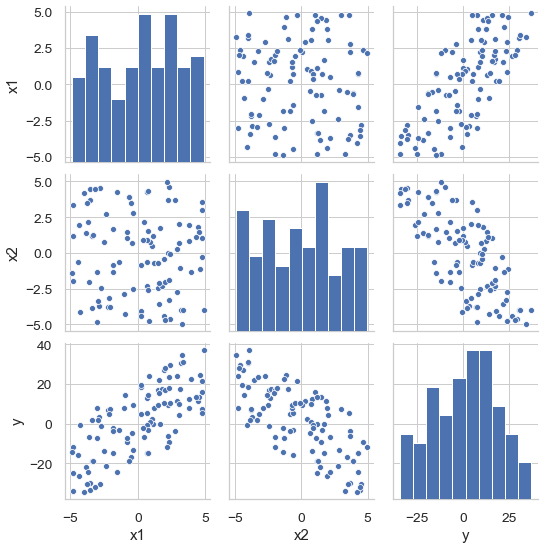

In [41]:
sns.pairplot(
    data=pd.DataFrame(np.hstack([x_ND, y_N[:,np.newaxis]]), columns=['x1', 'x2', 'y']));

In [42]:
# Define the optimization problem as an AUTOGRAD-able function wrt the weights w_D
def calc_squared_error_loss(w_D):
    return ag_np.sum(ag_np.square(ag_np.dot(x_ND, w_D) - y_N))

In [43]:
# Test the *loss function* at the known "ideal" initial point

calc_squared_error_loss(true_w_D)

1.6882674607128603

In [44]:
# Createa an all-zero weight array to use as our initial guess

init_w_D = np.zeros(2)

In [45]:
# Test the *loss function* at that all-zero initial point

calc_squared_error_loss(init_w_D)

30431.701153286307

In [46]:
# Use autograd.grad to build the gradient function

calc_grad_wrt_w = autograd.grad(calc_squared_error_loss)

In [47]:
# Test the gradient function at that same initial point 

calc_grad_wrt_w(init_w_D)

array([-7148.8368846 ,  7344.46400842])

### Discussion 4a: Is the gradient pointing in the right direction? Why or why not?

TODO discuss

### Run gradient descent

Use the code below to run GD on our simple regression problem

In [ ]:
# Because the gradient's magnitude is very large, use very small step size
opt_w_D, history = run_many_iters_of_gradient_descent(
    calc_loss, calc_grad_wrt_w, init_w_D,
    n_iters=400, step_size=0.00001,
    )

In [ ]:
# LinReg worked example
# Make plots of how w_D parameter values evolve over iterations, and function values evolve over iterations
# Expected result: x

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
for d in range(D):
    subplot_grid[0,0].plot(history['iter'], np.vstack(history['x_D'])[:,d], label='w[%d]' % d);
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('w_d')
subplot_grid[0,0].legend(loc='upper right')

subplot_grid[0,1].plot(history['iter'], history['f'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('-1 * log p(y | w, x)');

### Discussion 4b: Do these trace plots indicate we have converged to good weight vector values? Why or why not?

TODO discuss

# Part 5: Autograd for functions of data structures of arrays

#### Useful Fact: autograd can take derivatives with respect to DATA STRUCTURES of parameters

This can help us when it is natural to define models in terms of several parts (e.g. NN layers).

We don't need to turn our many model parameters into one giant weights-and-biases vector. We can express our thoughts more naturally.

### Demo 1: gradient of a LIST of parameters

In [ ]:
def f(w_list_of_arr):
    return ag_np.sum(ag_np.square(w_list_of_arr[0])) + ag_np.sum(ag_np.square(w_list_of_arr[1]))

g = autograd.grad(f)

In [ ]:
w_list_of_arr = [np.zeros(3), np.arange(5, dtype=np.float64)]

print("Type of the gradient is: ")
print(type(g(w_list_of_arr)))

print("Result of the gradient is: ")
g(w_list_of_arr)

### Demo 2: gradient of DICT of parameters


In [ ]:
def f(dict_of_arr):
    return ag_np.sum(ag_np.square(dict_of_arr['weights'])) + ag_np.sum(ag_np.square(dict_of_arr['bias']))
g = autograd.grad(f)

In [ ]:
dict_of_arr = dict(weights=np.arange(5, dtype=np.float64), bias=4.2)

print("Type of the gradient is: ")
print(type(g(dict_of_arr)))

print("Result of the gradient is: ")
g(dict_of_arr)

### Exercise 5a: Try to implement gradient descent for linear regression with weights and bias parameters

The above example only uses weights on the dimensions of each $x$ vector , and thus can only learn linear models that pass through the origin.

Can you instead optimize a model that includes a **bias** parameter $b>0$?

The predictions look like:

\begin{align}
\hat{y}(x_i) = w^T x_i + b
\end{align}

The training problem is:
    
\begin{align}
\min_{w \in \mathbb{R}^D,b \in \mathbb{R}} \sum_{n=1}^N (y_n - w^T x_n - b)^2
\end{align}


Use this format of parameter dictionary

In [ ]:
init_param_dict = dict(
    w_D=np.zeros(D),
    b=1.23)

Exercise 5a TODO: Define a function called `calc_loss` that computes our training loss given a parameter dictionary

In [ ]:
def calc_loss(param_dict):
    w_D = param_dict['w_D'] # Unpack weight array
    b = param_dict['b'] # Unpack bias scalar
    
    return 0.0 # TODO fix me


Exercise 5a TODO: build function `g` that can compute gradients

In [ ]:
g = None # TODO fix me

Given: use the implementation below of gradient descent on a parameter dictionary representation

In [ ]:
def run_many_iters_of_gradient_descent_for_param_dict(f, g, init_param_dict=None, n_iters=100, step_size=0.001):
    ''' Run many iterations of GD
    
    Args
    ---- 
    f : python function of dict to float
        Maps dict of arrays to scalar loss
    g : python function of dict to dict
        Maps dict of arrays to gradient dict of arrays
    init_param_dict : dict
        Initial values for the input parameters
    n_iters : int
        Number of gradient descent update steps to perform
    step_size : positive float
        Step size or learning rate for GD
        
    Returns
    -------
    opt_param_dict : dict
        Best value of parameter dict for provided loss f found via this GD procedure
    history : dict
        Contains history of this GD run useful for plotting diagnostics
    '''
    # Copy the initial parameter dict
    param_dict = copy.deepcopy(init_param_dict)

    # Create data structs to track the per-iteration history of different quantities
    history = dict(
        iter=[],
        f=[],
        param_dict=[],
        grad_dict=[])

    for iter_id in range(n_iters):
        if iter_id > 0:
            grad_dict = g(param_dict)
            for key in param_dict.keys():
                p_arr = param_dict[key] # current param array
                g_arr = grad_dict[key]  # current gradient array
                p_arr = p_arr - step_size * g_arr
                param_dict[key] = p_arr # store as latest value in dictionary

        history['iter'].append(iter_id)
        history['f'].append(f(param_dict))
        history['param_dict'].append(param_dict)
        history['grad_dict'].append(g(param_dict))
    return param_dict, history


TODO Run gradient descent to see what you get